In [9]:
%cd '/Users/bryan/Downloads/Peking_U/GlobalLocal/'

/Users/bryan/Downloads/Peking_U/GlobalLocal


In [10]:
import scipy.io as sio
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import time
import pickle
import h5py

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
import sklearn
from sklearn.metrics.scorer import make_scorer
from sklearn import svm
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
path = 'SEQ_pre_data/'
# path = 'SIM_pre_data/'

In [4]:
sub_folder = sorted([i for i in os.listdir(path) if 'sub' in i])


In [5]:
folder = path+sub_folder[2]+'/'

In [6]:
file_path = folder + sorted(os.listdir(folder))[-1]

In [7]:
# ## load all subjects' data
# DATA = []
# design = []
# for s in sub_folder:
#     folder = path+s+'/'
#     file_path = folder + sorted(os.listdir(folder))[-1]
#     tes = sio.loadmat(file_path)
#     data_tmp = (tes['data_clean_planar'][0,0][2]).copy()
#     data = np.zeros(data_tmp[0].shape + data_tmp[0][0].shape)
#     for i in range(data_tmp.shape[-1]):
#         data[i,] = data_tmp[0][i].copy()
#     del data_tmp
#     DATA.append(data)
#     design.append(tes['task_code'])
# Time = tes['data_clean_planar'][0,0][3][0,0].copy().reshape(-1)
# meg_data = np.concatenate(DATA,axis=0)
# design_matrix = np.concatenate(design,axis=0)
# hf = h5py.File(path + 'all_data.hdf5', "w")
# hf.create_dataset('MEG_data',compression="gzip", compression_opts=9,data=meg_data)
# hf.create_dataset('design_matrix',compression="gzip",compression_opts=9, data=design_matrix)
# hf.create_dataset('time', data=Time,compression="gzip",compression_opts=9)
# hf.close()

In [8]:
with h5py.File(path + 'all_data.hdf5', 'r') as f:
    data = f.get('MEG_data')[:]
    design_matrix = f.get('design_matrix')[:]
    Time = f.get('time')[:]

## Statistics

In [9]:
#Task design table 

df = pd.DataFrame(design_matrix,columns = ['type','angle_1','angle_2',
                                              'digitize_1','digitize_2','Performance'])
display(df)

,type,angle_1,angle_2,digitize_1,digitize_2,Performance
0,1,80,0,5,1,4
1,1,40,0,3,1,-16
2,1,140,120,8,7,1
3,1,160,140,9,8,6
4,1,0,0,1,1,-1
...,...,...,...,...,...,...
7852,2,40,100,3,6,1
7853,2,0,20,1,2,3
7854,1,40,160,3,9,4
7855,2,140,80,8,5,3


In [16]:
# df.groupby('digitize_1')['digitize_1'].unique()

digitize_1
1    [1]
2    [2]
3    [3]
4    [4]
5    [5]
6    [6]
7    [7]
8    [8]
9    [9]
Name: digitize_1, dtype: object

In [14]:
# df.groupby('type')['Performance'].agg('mean')

type
1   -0.029262
2    0.564553
Name: Performance, dtype: float64

#### sio.loadmat
```  
Data:
tes['data_clean_planar'][0,0]  
[0] : channel
[1] : label
[2] : signal
[3] : time
[4] : sample rate
[5] : 
    [0,0][0] trial id
    
 Task design   
 tes['task_code']
 
 column names:
 ['Global/local(1/2) Global orientation(angle)  Local orientation(angle)  Global orientation(1-9)
  Local orientation(1-9)  Performance difference']
 ```
 

## Decoding

In [9]:
label = design_matrix[:,0].reshape(-1)
ori_gb = design_matrix[:,3]
ori_lc = design_matrix[:,4]

In [10]:
from sklearn.preprocessing import StandardScaler
num_trials = data.shape[0]
stdScale = StandardScaler().fit(data.reshape((num_trials,-1)).T)
data = stdScale.transform(data.reshape((num_trials,-1)).T).T.reshape((num_trials,204,-1))

In [22]:
# plt.plot(Time,np.average(np.average(data[label == 1],axis = 0),axis = 0))
# plt.plot(Time,np.average(np.average(data[label == 2],axis = 0),axis = 0))
# plt.legend(['Global','Local'])

In [11]:
###Remove global response(minus average):
ave_over_gl_ori = [np.average(data[design_matrix[:,3]==i],axis = 0)for i in range(1,9)] 
for i in range(1,9):
    data[design_matrix[:,3]==i] = data[design_matrix[:,3]==i] - ave_over_gl_ori[i-1]   

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
# X = data[label == 2]
# y = ori_lc[label == 2]
y = np.concatenate([ori_lc]*1,axis = 0)
X = data[:,:,(Time>0)&(Time<2)][(y==2)|(y==5)|(y==8)]
y = y[(y==2)|(y==5)|(y==8)]
# clf = make_pipeline(svm.SVC(kernel='rbf'))
clf = make_pipeline(LogisticRegression(solver='lbfgs',
                                         multi_class = 'auto',
                                         random_state= 1,
                                         max_iter=1000))



time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)

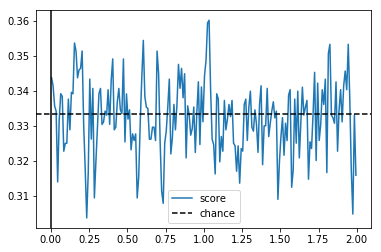

In [14]:
plt.plot(Time[(Time>0)&(Time<2)], score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

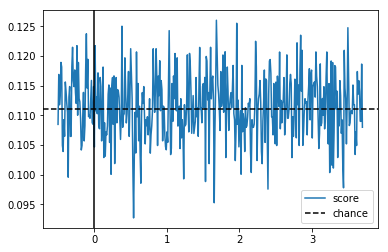

In [14]:
X = data[label == 2]
y = ori_lc[label == 2]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=300))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)
plt.plot(Time, scores, label='score')
plt.axhline(1/len(np.unique(ori_lc)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

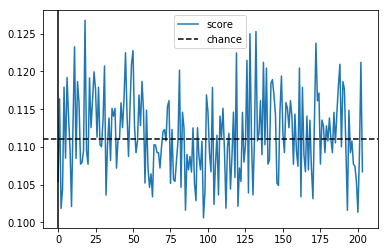

In [16]:
X = data[label == 2].swapaxes(2,1)
y = ori_lc[label == 2]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=300))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)
plt.plot(np.arange(data.shape[1]), scores, label='score')
plt.axhline(1/len(np.unique(ori_lc)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [19]:
data = data[label == 2]
ori_lc = ori_lc[label == 2]

In [37]:
np.unique(y)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int16)

In [23]:
lc = [data[:,:,(Time>i*0.5)&(Time<(i*0.5+0.5))] for i in range(4)]
lc = np.concatenate(lc,axis = 0)
X = lc.reshape(-1,lc.shape[1]*lc.shape[2])
y = np.concatenate([ori_lc]*4,axis = 0)
# define the model
model = RandomForestClassifier()

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [12]:
lc0 = [data[:,:,(Time>i*0.5)&(Time<(i*0.5+0.5))] for i in range(4)]
lc = np.concatenate(lc0,axis = 0)

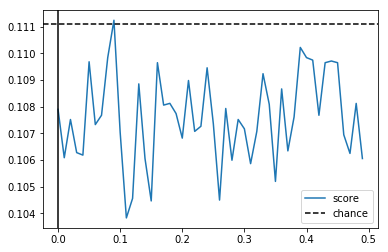

In [16]:
# y = np.concatenate([ori_lc]*4,axis = 0)
# y[(y<4)] = 1
# y[(y>3)&(y<7)] = 2
# y[(y>6)] = 3
y = np.concatenate([ori_lc]*4,axis = 0)
X = lc
# X = lc[(y==2)|(y==5)|(y==8)]
# y = y[(y==2)|(y==5)|(y==8)]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=1000))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# # Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
plt.plot(np.arange(lc.shape[-1])/lc.shape[-1]*0.5, score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [71]:
# y = np.concatenate([ori_lc]*4,axis = 0)
# y[(y<4)] = 1
# y[(y>3)&(y<7)] = 2
# y[(y>6)] = 3
y = np.concatenate([ori_lc]*1,axis = 0)
X = lc0[3][(y==2)|(y==5)|(y==8)]
y = y[(y==2)|(y==5)|(y==8)]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=300))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# # Mean scores across cross-validation splits
# scores = np.mean(scores, axis=0)

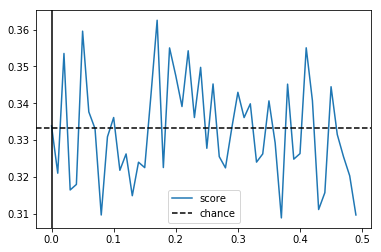

In [72]:
### 1500-2000ms  ori 2/5/8
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
plt.plot(np.arange(lc.shape[-1])/lc.shape[-1]*0.5, score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

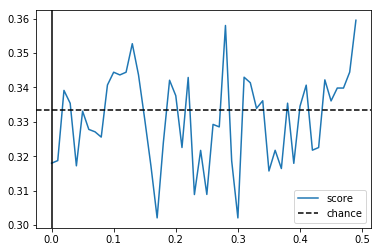

In [70]:

### 1000-1500ms  ori 2/5/8
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
plt.plot(np.arange(lc.shape[-1])/lc.shape[-1]*0.5, score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

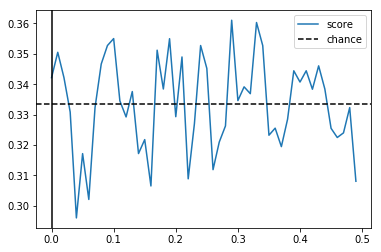

In [67]:
### 500-1000ms  ori 2/5/8
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
plt.plot(np.arange(lc.shape[-1])/lc.shape[-1]*0.5, score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

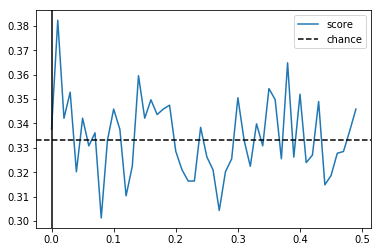

In [65]:
### 0-500ms  ori 2/5/8
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
plt.plot(np.arange(lc.shape[-1])/lc.shape[-1]*0.5, score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [73]:
y = np.concatenate([ori_lc]*1,axis = 0)
X = data[:,:,(Time<1)][(y==2)|(y==4)|(y==8)]
y = y[(y==2)|(y==4)|(y==8)]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=300))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# # Mean scores across cross-validation splits
# scores = np.mean(scores, axis=0)

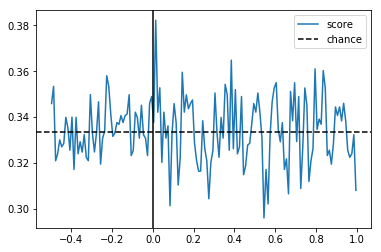

In [76]:
score = np.mean(scores, axis=0)
plt.plot(Time[Time<1], score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [40]:
X = data[label == 1][:,:,(time>0)&(time<0.5)].reshape(-1,data.shape[1]*lc.shape[-1])
y = ori_gl[label == 1]
model = RandomForestClassifier()

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3927 but corresponding boolean dimension is 7857

In [ ]:
X = data[label == 2]
y = ori_lc[label == 2]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=300))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

In [ ]:
plt.plot(time, scores, label='score')
plt.axhline(1/len(np.unique(ori_lc)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

### global 

In [7]:
with h5py.File(path + 'all_data.hdf5', 'r') as f:
    data = f.get('MEG_data')[:]
    design_matrix = f.get('design_matrix')[:]
    Time = f.get('time')[:]

In [10]:
label = design_matrix[:,0].reshape(-1)
ori_gb = design_matrix[:,3]
ori_lc = design_matrix[:,4]
data = data[label == 1]
ori_gb = ori_gb[label == 1]

In [13]:
gb0 = [data[:,:,(Time>i*0.5)&(Time<(i*0.5+0.5))] for i in range(4)]
gb = np.concatenate(gb0,axis = 0)

In [ ]:


#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [37]:
y = np.concatenate([ori_gb]*1,axis = 0)
X = data[:,:,(Time>0)&(Time<1)][(y==2)|(y==4)|(y==8)]
y = y[(y==2)|(y==5)|(y==8)]
clf = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf'))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

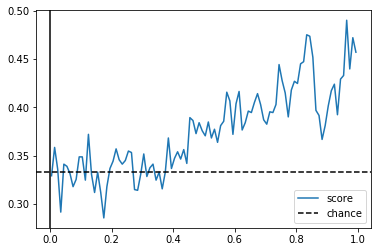

In [39]:
score = np.mean(scores, axis=0)
plt.plot(Time[(Time>0)&(Time<1)], score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [24]:
y = np.concatenate([ori_gb]*1,axis = 0)
X = data[(y==2)|(y==5)|(y==8)]
y = y[(y==2)|(y==5)|(y==8)]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=1000))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

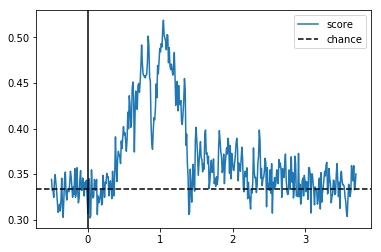

In [25]:
score = np.mean(scores, axis=0)
plt.plot(Time, score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

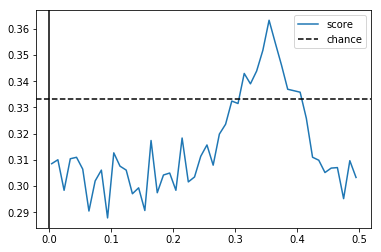

In [18]:
## all 2/5/8

score = np.mean(scores, axis=0)
plt.plot(Time[(Time<0.5)&(Time>0)], score, label='score')
plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

In [24]:
##temporal search light
X = data[label == 1]
y = ori_gb[label == 1]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=300))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

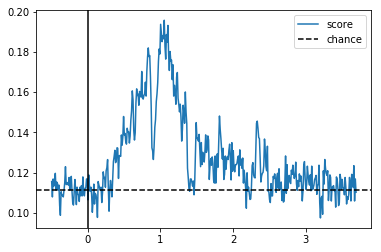

In [27]:
plt.plot(Time, scores, label='score')
plt.axhline(1/len(np.unique(ori_gb)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()


In [34]:
X = data[label == 1 ].swapaxes(2,1)
y = ori_gb[label == 1]
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',
                                                         multi_class = 'auto',
                                                         random_state= 1,
                                                         max_iter=300))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring= 'accuracy', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

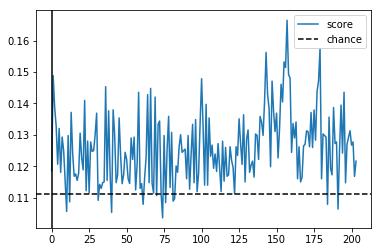

In [35]:
## channel-wise
plt.plot(np.arange(data.shape[1]), scores, label='score')
plt.axhline(1/len(np.unique(ori_gb)), color='k', linestyle='--', label='chance')
# plt.set_xlabel('Times')
# plt.set_ylabel('ACC')  # Area Under the Curve
plt.axvline(.0, color='k', linestyle='-')
plt.legend()

